In [1]:
import librosa
import numpy as np
from scipy.signal import get_window, freqz
from scipy.linalg import toeplitz, solve_toeplitz

import matplotlib.pyplot as plt

from util import plot_signal, compute_stft, plot_log_magnitude
%matplotlib widget


file = "speech1.wav"

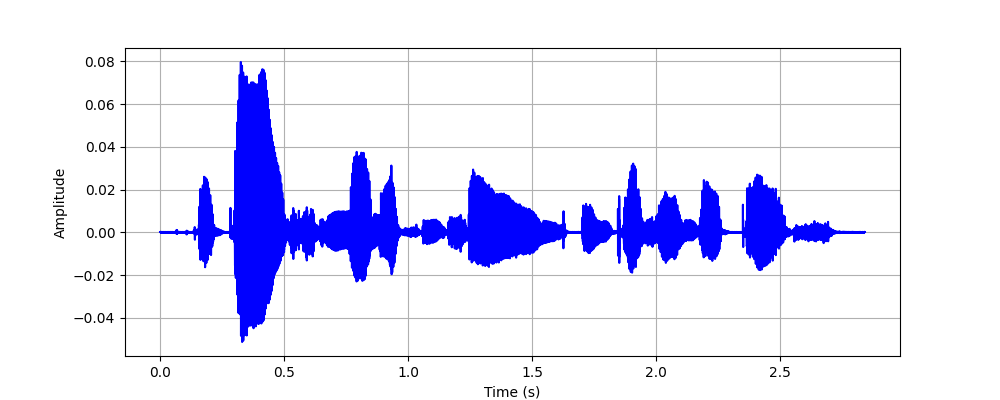

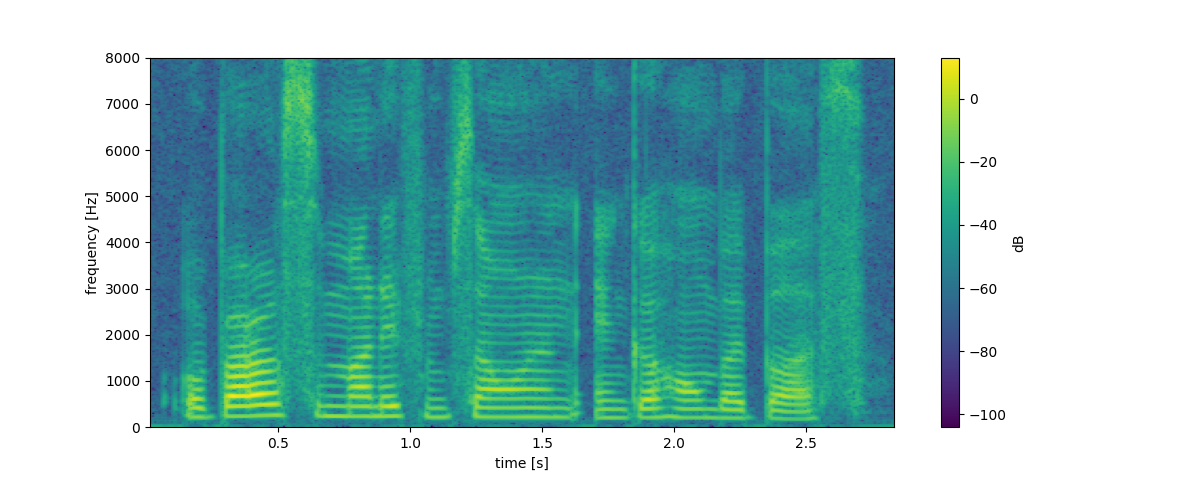

In [2]:
y, sr = librosa.load(file, sr=None)

plot_signal(y, sr)

v_hann_window = get_window("hann", int(sr * 32 / 1000), True)
plot_log_magnitude(*compute_stft(y, sr, 32, 8, v_hann_window))


2. Select one unvoiced and one voiced speech segment from the signal, each with a length of 32 ms. You may reuse
your segmentation from Assignment 3 of Exercise 1 and/or your knowledge about the speech signal obtained in
assignment 1b) of Exercise 1. Apply a Hann window of the same length to both segments

In [3]:
segment_length_ms = 32

def get_segment(y: np.ndarray, t0_ms: int, length_ms: int = 32) -> np.ndarray:
    # convert ms to samples
    length = int(sr * length_ms / 1000)
    t0 = int(sr * t0_ms / 1000)
    t1 = t0 + length
    
    # get segment
    v_seg = y[t0:t1]

    # apply hann window
    v_hann_window = get_window("hann", length, True)
    return v_seg * v_hann_window


voiced_segment = get_segment(y, 300)
unvoiced_segment = get_segment(y, 550)

3. Compute the $M = 12$-order LP coefficients by solving equation 4. Use the functions `np.correlate` and `scipy.linalg.solve_toeplitz` to compute the autocorrelation vector $\phi_s$ and the correlation matrix $R_s$ respectively. Store the coefficients in a vector $a$.

In [4]:
print("Control: Librosa Linear Prediction Coefficients (voiced segment)\n", librosa.lpc(voiced_segment, order=12))
print("Control: Librosa Linear Prediction Coefficients (voiced segment)\n", librosa.lpc(unvoiced_segment, order=12))

Control: Librosa Linear Prediction Coefficients (voiced segment)
 [ 1.         -2.71947183  2.43385814  0.30427874 -2.34438971  1.79651275
  0.13282822 -1.24591612  0.92271324 -0.17107457 -0.01581462 -0.14877414
  0.12690826]
Control: Librosa Linear Prediction Coefficients (voiced segment)
 [1.         0.94438622 0.14828399 0.21340102 0.36157487 0.3282959
 0.4661365  0.20472209 0.17252326 0.3037789  0.12122428 0.02902136
 0.08407856]


In [6]:
def get_coefficients(y: np.ndarray, lpc_order: int = 12) -> np.ndarray:
    # compute the autocorrelation vector
    phi_full = np.correlate(y, y, mode="full")  # mode "valid" | "full"

    # autocorrelation is symmetric, we only need one half
    center = len(phi_full) // 2
    phi = phi_full[center:center + lpc_order + 1]

    R = toeplitz(phi[:-1])  # The matrix is formed by the first 12 elements of phi_voiced
    r = phi[1:]            # The right-hand side vector is the remaining part

    # Solve for the LPC coefficients
    a = solve_toeplitz((phi[:-1], phi[:-1]), r)

    return -a

a_voiced = get_coefficients(voiced_segment)
print("Linear Prediction Coefficients (voiced segment):\n", a_voiced)

a_unvoiced = get_coefficients(unvoiced_segment)
print("Linear Prediction Coefficients (unvoiced segment):\n", a_unvoiced)

Linear Prediction Coefficients (voiced segment):
 [-2.71947241  2.43385937  0.30427807 -2.34439051  1.79651446  0.1328271
 -1.24591675  0.92271501 -0.17107573 -0.01581519 -0.14877269  0.12690752]
Linear Prediction Coefficients (unvoiced segment):
 [0.94438624 0.148284   0.21340097 0.36157487 0.32829589 0.46613646
 0.20472208 0.17252316 0.30377886 0.12122441 0.02902129 0.08407841]


4a) Make a plot of the frequency response (amplitude as well as phase) of the estimated vocal tract filter $H(z)$ for both, the unvoiced and the voiced speech segment. To do this, the command `scipy.signal.freqz(1, np.concatenate(([1], a)), numPoints, whole=True, fs=sampling_freq)` might be helpful. For the number of frequency-points (`numPoints`), use the segment length in samples. Make sure that the axis descriptions of your plots is meaningful.

4b) Why do you use `np.concatenate(([1], a))` and not only a?

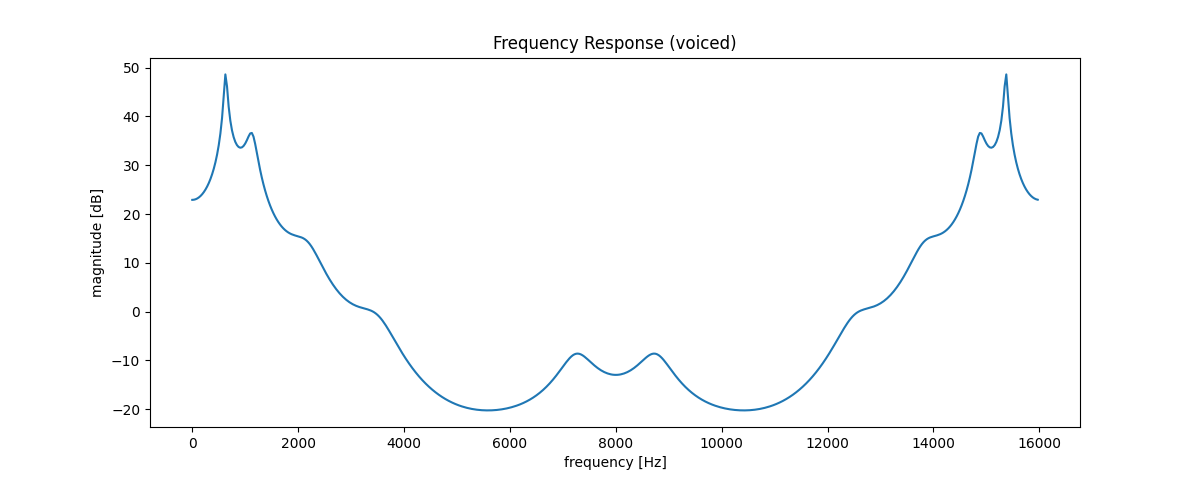

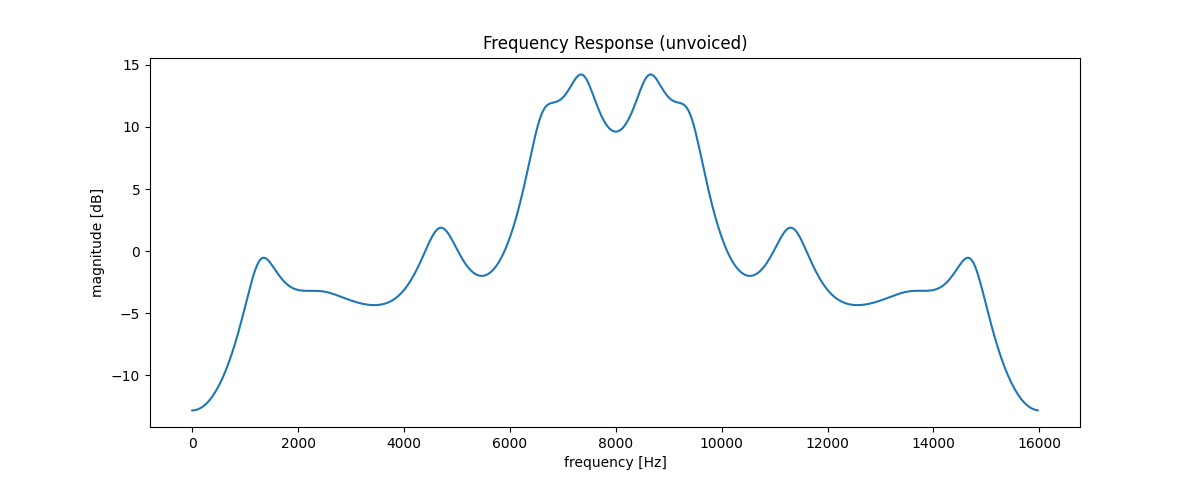

In [19]:
def plot_freq_response(lpc: np.ndarray, num_points: int, title: str = ""):
    w, h = freqz(1, np.concatenate(([1], lpc)), num_points, whole=True, fs=sr)
    
    
    fig = plt.figure()
    fig.set_figwidth(12)

    ax = fig.add_subplot(111)
    ax.title.set_text(f"Frequency Response ({title})")
    ax.set_xlabel("frequency [Hz]")
    ax.set_ylabel("magnitude [dB]")
    ax.plot(w, 20*np.log10(np.abs(h)))


num_points = int(sr * 32 / 1000)

plot_freq_response(a_voiced, num_points, "voiced")
plot_freq_response(a_unvoiced, num_points, "unvoiced")